This notebook will define the fuzzy systems for the following three features:
- Torso Angle (relative to the horizontal)
- Heel Vertical Position (relative to the toe)
- Vertical Distance between Hips and Knees (normalised by the thigh length)

The membership function that defines the correct range of inputs will be designed based on the error values in the training data (relative to the regression models). These error values have already been calculated, therefore all that is needed is to import the error arrays for concentric and eccentric contraction.

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

In [2]:
#Import the error arrays
err_con = np.load('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 3\\Feedback\\Data\\Concentric Error.npy')
err_ecc = np.load('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 3\\Feedback\\Data\\Eccentric Error.npy')

#Calculate the mean and standard deviation of the errors for each feature.
err_con_mean = np.round(np.mean(err_con, axis=1),3)
err_con_std = np.round(np.std(err_con, axis=1),3)
err_ecc_mean = np.round(np.mean(err_ecc, axis=1),3)
err_ecc_std = np.round(np.std(err_ecc, axis=1),3)

In [4]:
np.savetxt('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 3\\Feedback\\Data\\Side Concentric Error.txt', err_con)
np.savetxt('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 3\\Feedback\\Data\\Side Eccentric Error.txt', err_ecc)

In [6]:
err_con_std*180

array([ 8.1 ,  5.58, 12.42])

# Initial Membership Function Design
I will initiate the membership functions for all features in the following ways.
### "Correct" membership function design
Based on the above data, the trapezoidal membership functions will be defined as follows:
- Symetrical
- Centre is at the mean
- Flat part finishes at +2*std and -2*std
- Membership function drops to zero at +3*std and -3*std

These are just arbitrary choices, but the reason is that two and three standard deviations capture approximately 95% and 99.7% of the data, respectively. This seems like a good starting point.

### Other membership functions design
Easiest way to define these membership functions is based on the standard deviation of the "correct" data. 
- make the "Medium_neg" and "Medium_pos" functions to overlap the "correct" function by 1 standard deviation of the correct data. 
- make the "Medium_neg" and "Medium_pos" functions have a flat section spanning 2 standard deviations (same as the half of the "correct" function.
- make the "Large_neg" and "Large_pos" overlap the medium functions the same as the medium functions overlaps with the correct function.
- make the Large functions then increase to 0 within 1 standard deviation, then this stays flat until the edge of the range.

This is just an approjimation, the "correct" mambership function will be far more accurate than the other two, but if things need to be changed this can be done later, either manually or algorithm based.

# Improved Membership Function Design
After acquiring some examples showing incorrect technique (I filmed these myself) I have tweaked the membership functions. The membership functions are not quite defined exactly how they were initially defined. The new membership functions are far from optimal, but they do seem to give results that make more sense (at least on the videos that I have acquired).

Now I can proceed to defining the systems

# Inputs for Torso Angle
Express all the angles in degrees, since it is more interpretable to me that the normalised value from 0 to 1 that is is currently.

## Concentric

### Angular Inputs

C:\Users\Cian\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


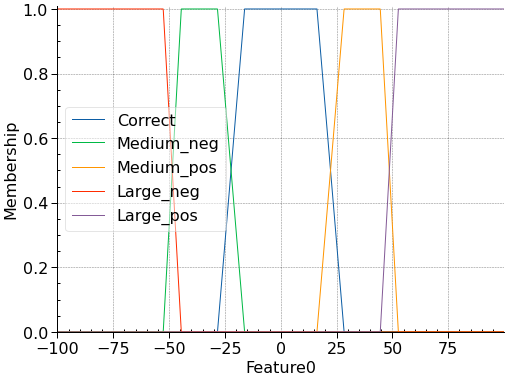

In [216]:
#Define the number of points that will define the trajectories.
N=15

#define angular inputs
feat0_inputs = {}
for i in range(N):
    feat0_inputs[f'Feature{i}'] = ctrl.Antecedent(np.arange(-100,100,0.1),f'Feature{i}')
    
#Acquire the values for defining the "correct" membership function
corr = np.array([err_con_mean[0]-3.5*err_con_std[0],err_con_mean[0]-2*err_con_std[0], err_con_mean[0]+2*err_con_std[0], err_con_mean[0]+3.5*err_con_std[0]])*180
med_neg = np.array([corr[0]-3*err_con_std[0]*180, corr[0]-2*err_con_std[0]*180, corr[0], corr[1]])
med_pos = np.array([corr[-2], corr[-1], corr[-1]+2*err_con_std[0]*180, corr[-1]+3*err_con_std[0]*180])
lar_neg = np.array([-100, -100, med_neg[0], med_neg[1]])
lar_pos = np.array([med_pos[-2], med_pos[-1],100,100])
    
# now fuzzify each input
for j in range(N):
    feat0_inputs[f'Feature{j}']['Correct'] = fuzz.trapmf(feat0_inputs[f'Feature{j}'].universe, corr)
    feat0_inputs[f'Feature{j}']['Medium_neg'] = fuzz.trapmf(feat0_inputs[f'Feature{j}'].universe, med_neg)
    feat0_inputs[f'Feature{j}']['Medium_pos'] = fuzz.trapmf(feat0_inputs[f'Feature{j}'].universe, med_pos)
    feat0_inputs[f'Feature{j}']['Large_neg'] = fuzz.trapmf(feat0_inputs[f'Feature{j}'].universe, lar_neg)
    feat0_inputs[f'Feature{j}']['Large_pos'] = fuzz.trapmf(feat0_inputs[f'Feature{j}'].universe, lar_pos)

feat0_inputs['Feature0'].view()

# Inputs for Heel Height

First problem is to define the range of the input. Acquire a value for this based on approximation of the maximum that it can be.
- Maximum height that the heel can be above the toe is the foot length.
- The heel height is normalised by the thigh length.
- I can safely estimate that no one's foot length will be more than half the length of their thigh.
- Based on the above points, the maximum the error can be is twice this estimate for the maximum ratio of foot length to thigh length.

Therefore the range will be [-1, 1]

C:\Users\Cian\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


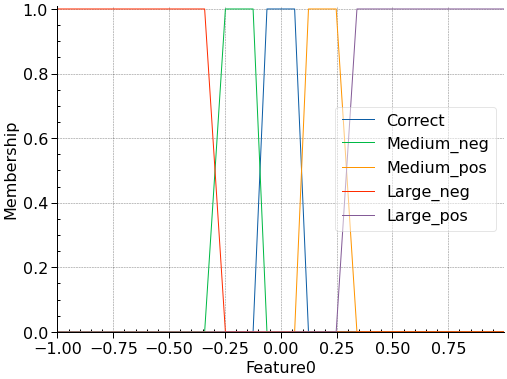

In [175]:
#define angular inputs
feat1_inputs = {}
for i in range(N):
    feat1_inputs[f'Feature{i}'] = ctrl.Antecedent(np.arange(-1,1,0.001),f'Feature{i}')
    
#Acquire the values for defining the "correct" membership function
corr = np.array([err_con_mean[1]-4*err_con_std[1],err_con_mean[1]-2*err_con_std[1], err_con_mean[1]+2*err_con_std[1], err_con_mean[1]+4*err_con_std[1]])
med_neg = np.array([corr[0]-7*err_con_std[1], corr[0]-4*err_con_std[1], corr[0], corr[1]])
med_pos = np.array([corr[-2], corr[-1], corr[-1]+4*err_con_std[1], corr[-1]+7*err_con_std[1]])
lar_neg = np.array([-1, -1, med_neg[0], med_neg[1]])
lar_pos = np.array([med_pos[-2], med_pos[-1],1,1])
    
# now fuzzify each input
for j in range(N):
    feat1_inputs[f'Feature{j}']['Correct'] = fuzz.trapmf(feat1_inputs[f'Feature{j}'].universe, corr)
    feat1_inputs[f'Feature{j}']['Medium_neg'] = fuzz.trapmf(feat1_inputs[f'Feature{j}'].universe, med_neg)
    feat1_inputs[f'Feature{j}']['Medium_pos'] = fuzz.trapmf(feat1_inputs[f'Feature{j}'].universe, med_pos)
    feat1_inputs[f'Feature{j}']['Large_neg'] = fuzz.trapmf(feat1_inputs[f'Feature{j}'].universe, lar_neg)
    feat1_inputs[f'Feature{j}']['Large_pos'] = fuzz.trapmf(feat1_inputs[f'Feature{j}'].universe, lar_pos)

feat1_inputs['Feature0'].view()

# Inputs for Vertical Distance from Hip to Knee

Apply a very similar approach to defining the allowable range of the input values.
- The maximum possible vertical distance between the hips and the knees is equal to the length of the thigh.
- This length is normalised by the thigh length, therefore the maximum possible value of this is 1 (this can be -1 too).
- Therefore, the maximum possible value of the error is twice the maximum value for the ratio estimated in the last bullet point.

The range will be [-2,2]

C:\Users\Cian\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


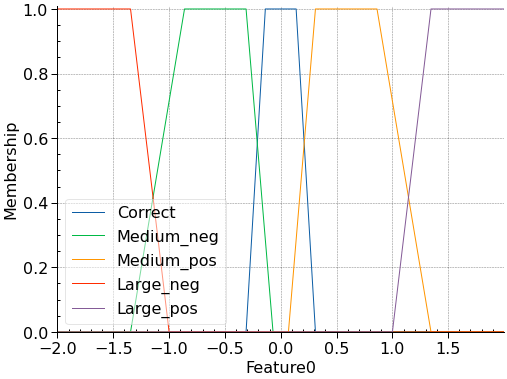

In [295]:
#define angular inputs
feat2_inputs = {}
for i in range(N):
    feat2_inputs[f'Feature{i}'] = ctrl.Antecedent(np.arange(-2,2,0.001),f'Feature{i}')
    
#Acquire the values for defining the "correct" membership function
corr = np.array([err_con_mean[2]-4.5*err_con_std[2],err_con_mean[2]-2*err_con_std[2], err_con_mean[2]+2*err_con_std[2], err_con_mean[2]+4.5*err_con_std[2]])
med_neg = np.array([corr[0]-15*err_con_std[2], corr[0]-8*err_con_std[2], corr[0], corr[1]+err_con_std[2]])
med_pos = np.array([corr[-2]-err_con_std[2], corr[-1], corr[-1]+8*err_con_std[2], corr[-1]+15*err_con_std[2]])
lar_neg = np.array([-2, -2, med_neg[0], med_neg[1]-2*err_con_std[2]])
lar_pos = np.array([med_pos[-2]+2*err_con_std[2], med_pos[-1],2,2])
    
# now fuzzify each input
for j in range(N):
    feat2_inputs[f'Feature{j}']['Correct'] = fuzz.trapmf(feat2_inputs[f'Feature{j}'].universe, corr)
    feat2_inputs[f'Feature{j}']['Medium_neg'] = fuzz.trapmf(feat2_inputs[f'Feature{j}'].universe, med_neg)
    feat2_inputs[f'Feature{j}']['Medium_pos'] = fuzz.trapmf(feat2_inputs[f'Feature{j}'].universe, med_pos)
    feat2_inputs[f'Feature{j}']['Large_neg'] = fuzz.trapmf(feat2_inputs[f'Feature{j}'].universe, lar_neg)
    feat2_inputs[f'Feature{j}']['Large_pos'] = fuzz.trapmf(feat2_inputs[f'Feature{j}'].universe, lar_pos)

feat2_inputs['Feature0'].view()

# Next Steps
Next I need to define the:
- time inputs (same as for prototype 2)
- outputs
- logical rules
These will be the exact same for all systems, therefore, it is better to only define them once.

### Time Inputs

C:\Users\Cian\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


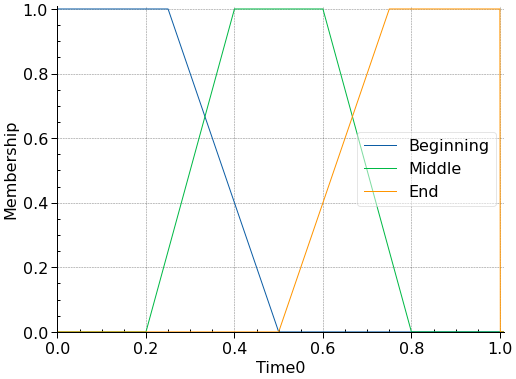

In [91]:
#Identical to what was defined in Prototype 2
t_inputs = {}
for i in range(N):
    t_inputs[f'Time{i}'] = ctrl.Antecedent(np.arange(0,1.01,0.001),f'Time{i}')

#now fuzzify each input
for j in range(N):
    t_inputs[f'Time{j}']['Beginning'] = fuzz.trapmf(t_inputs[f'Time{j}'].universe, [0,0,0.25,0.5])
    t_inputs[f'Time{j}']['Middle'] = fuzz.trapmf(t_inputs[f'Time{j}'].universe, [0.2,0.4,0.6,0.8])
    t_inputs[f'Time{j}']['End'] = fuzz.trapmf(t_inputs[f'Time{j}'].universe, [0.5,0.75,1,1])
    
t_inputs['Time0'].view()

### Define Outputs
Note that I have defined the outputs to range between -1.5 and 1.5. The reason for this is because in order for the output to range between -1 and 1 the centroid of the membership functions at both extremes must be equal to -1 and 1.

C:\Users\Cian\anaconda3\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


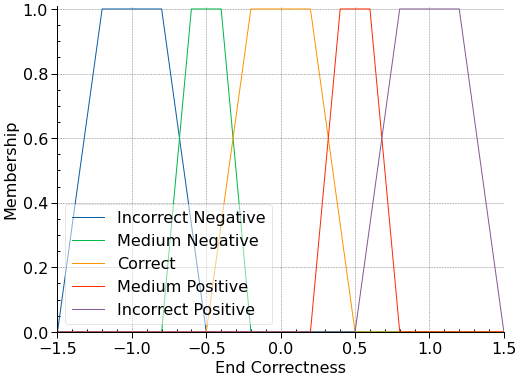

In [92]:
#Identical to what was defined in Prototype 2

beg_corr = ctrl.Consequent(np.arange(-1.5, 1.51, 0.01), 'Beginning Correctness')
mid_corr = ctrl.Consequent(np.arange(-1.5, 1.51, 0.01), 'Middle Correctness')
end_corr = ctrl.Consequent(np.arange(-1.5, 1.51, 0.01), 'End Correctness')

#Now define its membership functions for beginning
beg_corr['Incorrect Negative'] = fuzz.trapmf(beg_corr.universe,[-1.5,-1.2,-0.8,-0.5])
beg_corr['Medium Negative'] = fuzz.trapmf(beg_corr.universe,[-0.8,-0.6,-0.4,-0.2])
beg_corr['Correct'] = fuzz.trapmf(beg_corr.universe,[-0.5,-0.2,0.2,0.5])
beg_corr['Medium Positive'] = fuzz.trapmf(beg_corr.universe,[0.2,0.4,0.6,0.8])
beg_corr['Incorrect Positive'] = fuzz.trapmf(beg_corr.universe,[0.5,0.8,1.2,1.5])

#Now define its membership functions for middle
mid_corr['Incorrect Negative'] = fuzz.trapmf(mid_corr.universe,[-1.5,-1.2,-0.8,-0.5])
mid_corr['Medium Negative'] = fuzz.trapmf(mid_corr.universe,[-0.8,-0.6,-0.4,-0.2])
mid_corr['Correct'] = fuzz.trapmf(mid_corr.universe,[-0.5,-0.2,0.2,0.5])
mid_corr['Medium Positive'] = fuzz.trapmf(mid_corr.universe,[0.2,0.4,0.6,0.8])
mid_corr['Incorrect Positive'] = fuzz.trapmf(mid_corr.universe,[0.5,0.8,1.2,1.5])

#Now define its membership functions for end
end_corr['Incorrect Negative'] = fuzz.trapmf(end_corr.universe,[-1.5,-1.2,-0.8,-0.5])
end_corr['Medium Negative'] = fuzz.trapmf(end_corr.universe,[-0.8,-0.6,-0.4,-0.2])
end_corr['Correct'] = fuzz.trapmf(end_corr.universe,[-0.5,-0.2,0.2,0.5])
end_corr['Medium Positive'] = fuzz.trapmf(end_corr.universe,[0.2,0.4,0.6,0.8])
end_corr['Incorrect Positive'] = fuzz.trapmf(end_corr.universe,[0.5,0.8,1.2,1.5])

end_corr.view()

### Define Logic-Based Rules
I will define these as a function, so that I can apply it to each feature.

In [93]:
#This function takes in the feature that is being analysed (0 = torso angle; 1 = heel height; 2 = hip to knee vert height).
#This function returns a set of rules that will be used to create each system.
def Rules(feat):        
    #initiallize an empty list that will contain all the rules.
    rules = []

    for i in range(N-1):
        #First identify which of the possible features I am analysing
        if feat == 0:
            feature = feat0_inputs[f'Feature{i}']
            feature_next = feat0_inputs[f'Feature{i+1}']
        elif feat == 1:
            feature = feat1_inputs[f'Feature{i}']
            feature_next = feat1_inputs[f'Feature{i+1}']
        elif feat == 2:
            feature = feat2_inputs[f'Feature{i}']
            feature_next = feat2_inputs[f'Feature{i+1}']
            
        #if all points are accurate in the beginning section, then the technique is correct.
        #First apply this to the beginning
        rules.append(ctrl.Rule(feature['Correct']&feature_next['Correct']&t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning'], beg_corr['Correct']))

        #Repeat the above for middle time
        rules.append(ctrl.Rule(feature['Correct']&feature_next['Correct']&t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle'], mid_corr['Correct']))

        #Same for the end
        rules.append(ctrl.Rule(feature['Correct']&feature_next['Correct']&t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End'], end_corr['Correct']))



        #If one point is showing medium error then the technique should be of medium correctness.
        #First apply this to the beginning
        rules.append(ctrl.Rule((feature['Medium_pos']|feature_next['Medium_pos'])&(t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning']), beg_corr['Medium Positive']))
        rules.append(ctrl.Rule((feature['Medium_neg']|feature_next['Medium_neg'])&(t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning']), beg_corr['Medium Negative']))

        #Now apply to middle
        rules.append(ctrl.Rule((feature['Medium_pos']|feature_next['Medium_pos'])&(t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle']), mid_corr['Medium Positive']))
        rules.append(ctrl.Rule((feature['Medium_neg']|feature_next['Medium_neg'])&(t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle']), mid_corr['Medium Negative']))

        #Now apply to end
        rules.append(ctrl.Rule((feature['Medium_pos']|feature_next['Medium_pos'])&(t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End']), end_corr['Medium Positive']))
        rules.append(ctrl.Rule((feature['Medium_neg']|feature_next['Medium_neg'])&(t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End']), end_corr['Medium Negative']))


        #If one point is showing large error then the technique should be of low correctness.
        rules.append(ctrl.Rule((feature['Large_pos']|feature_next['Large_pos'])&(t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning']), beg_corr['Incorrect Positive']))
        rules.append(ctrl.Rule((feature['Large_neg']|feature_next['Large_neg'])&(t_inputs[f'Time{i}']['Beginning']&t_inputs[f'Time{i+1}']['Beginning']), beg_corr['Incorrect Negative']))

        #Now apply to middle
        rules.append(ctrl.Rule((feature['Large_pos']|feature_next['Large_pos'])&(t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle']), mid_corr['Incorrect Positive']))
        rules.append(ctrl.Rule((feature['Large_neg']|feature_next['Large_neg'])&(t_inputs[f'Time{i}']['Middle']&t_inputs[f'Time{i+1}']['Middle']), mid_corr['Incorrect Negative']))

        #Now apply to end
        rules.append(ctrl.Rule((feature['Large_pos']|feature_next['Large_pos'])&(t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End']), end_corr['Incorrect Positive']))
        rules.append(ctrl.Rule((feature['Large_neg']|feature_next['Large_neg'])&(t_inputs[f'Time{i}']['End']&t_inputs[f'Time{i+1}']['End']), end_corr['Incorrect Negative']))
    
    #return the rules list
    return rules

# Create the Fuzzy Inference Systems

In [296]:
sys_torso = ctrl.ControlSystem(Rules(0))
sys_heel = ctrl.ControlSystem(Rules(1))
sys_hip_knee = ctrl.ControlSystem(Rules(2))

### Apply System to Real Examples
I will now code a script that uses the classification model and the regression "perfect technique" model to create inputs to the fuzzy logic system. This will complete this section

In [1]:
import sys
sys.path.append("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Functions")
from Functions_Squat import signed_error

In [2]:
# con_err, con_interp, corr_con, ecc_err, ecc_interp, corr_ecc = signed_error(15, "C:\\Users\\Cian\\Downloads\\Squat Vids\\1 (1).mp4")
con_err, con_interp, corr_con, ecc_err, ecc_interp, corr_ecc = signed_error(15, "C:\\Users\\Cian\\Downloads\\front.mp4")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[ 0.6         1.73333333  2.66666667  3.6         5.06666667  6.26666667
  7.8         9.26666667 11.2       ]
Front


In [8]:
con_interp.shape, ecc_interp.shape

[-19.66685524 -12.5525938  -13.62994002  -6.43952905  -3.40424841
  -2.21240085  -2.0186962   -1.67607161  -1.63712955  -4.48610228
  -3.10486582  -1.31597291  -8.6617996   -7.90993973  -9.40048153]
[ -9.19115514 -10.56638193 -11.67904581  -8.6971005   -5.85156496
  -6.00125596  -7.68481803  -1.51228433  -3.92664637  -0.39457108
  -4.29876432  -9.22477668 -11.54512878 -15.90210531 -20.33985257]


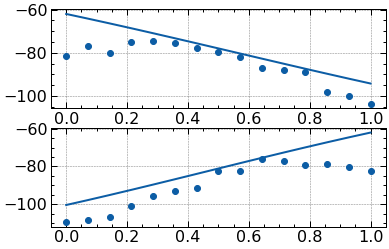

In [10]:
fig, (ax0,ax1) = plt.subplots(2)
t = np.linspace(0,1,N)

rep = 0
feat = 0

ax0.scatter(t,con_interp[rep,:,feat]*180/np.pi)
ax0.plot(t,corr_con[rep,:,feat]*180/np.pi)
print(con_err[rep,:,feat]*180/np.pi)

ax1.scatter(t,ecc_interp[rep,:,feat]*180/np.pi)
ax1.plot(t,corr_ecc[rep,:,feat]*180/np.pi)
print(ecc_err[rep,:,feat]*180/np.pi)

In [355]:
simulation = ctrl.ControlSystemSimulation(sys_torso)
T = np.linspace(0,1,N)
for i in range(N):
    simulation.input[f'Feature{i}'] = con_err[rep,i,feat]*180
    simulation.input[f'Time{i}'] = T[i]
simulation.compute()
np.round(simulation.output['Beginning Correctness'],3), np.round(simulation.output['Middle Correctness'],3), np.round(simulation.output['End Correctness'],3)

(0.118, 0.214, 0.07)

In [356]:
simulation = ctrl.ControlSystemSimulation(sys_torso)
T = np.linspace(0,1,N)
for i in range(N):
    simulation.input[f'Feature{i}'] = ecc_err[rep,i,feat]*180
    simulation.input[f'Time{i}'] = T[i]
simulation.compute()
np.round(simulation.output['Beginning Correctness'],3), np.round(simulation.output['Middle Correctness'],3), np.round(simulation.output['End Correctness'],3)

(0.0, 0.0, 0.0)